# Assignment 2: Training the Fully Recurrent Network

*Author:* Thomas Adler

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.


## Exercise 1: Data generation

There are two classes, both occurring with probability 0.5. There is one input unit. Only the first sequence element conveys relevant information about the class. Sequence elements at positions $t > 1$ stem from a Gaussian with mean zero and variance 0.2. The first sequence element is 1.0 (-1.0) for class 1 (2). Target at sequence end is 1.0 (0.0) for class 1 (2)

Write a function `generate_data` that takes an integer `T` as argument which represents the sequence length. Seed the `numpy` random generator with the number `0xDEADBEEF`. Implement the [Python3 generator](https://docs.python.org/3/glossary.html#term-generator) pattern and produce data in the way described above. The input sequences should have the shape `(T, 1)` and the target values should have the shape `(1,)`.

In [8]:
%matplotlib inline
import numpy as np
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt

class FullyRecurrentNetwork(object):
    def __init__(self, D, I, K):
        self.W = np.random.uniform(-0.01, 0.01, (I, D))
        self.R = np.random.uniform(-0.01, 0.01, (I, I))
        self.V = np.random.uniform(-0.01, 0.01, (K, I))

    def forward(self, x, y):
        # helper function for numerically stable loss
        def f(z):
            return np.log1p(np.exp(-np.absolute(z))) + np.maximum(0, z)

        # infer dims
        T, D = x.shape
        K, I = self.V.shape

        # init result arrays
        self.x = x
        self.y = y
        self.a = np.zeros((T, I))

        # iterate forward in time
        # trick: access model.a[-1] in first iteration
        for t in range(T):
            self.a[t] = np.tanh(self.W @ x[t] + self.R @ self.a[t-1])

        self.z = model.V @ self.a[t]
        return y * f(-self.z) + (1-y) * f(self.z)

T, D, I, K = 10, 3, 5, 1
model = FullyRecurrentNetwork(D, I, K)
model.forward(np.random.uniform(-1, 1, (T, D)), 1)

def generate_data(T):
    ########## YOUR SOLUTION HERE ##########

    #    X[0] =  1, y =  1 -> class 1
    #    X[0] = -1, y =  0 -> class 2

    # set seed
    rng = np.random.default_rng(int('0xDEADBEEF', 16))
    # set mean and variance for the guassian dist.
    mu, variance = 0, 0.2
    sigma =  np.sqrt(variance)

    while True:
        x = np.empty((T,1))
        # generate x0, y0
        # create a random no either 0 or 1 for the class with prob 0.5 for each, then use it to access array of [-1,1]
        y_t = np.random.randint(low=0, high=2)
        x[0] = [-1,1][y_t]

        # generate rest of the sequence
        for i in range(1,T):
            x[i] = rng.normal(mu, sigma, 1)

        yield x, np.array([y_t])

data = generate_data(2)
data



<generator object generate_data at 0x7f0efff01d20>

## Exercise 2: Gradients for the network parameters
Compute gradients of the total loss
$$
L = \sum_{t=1}^T L(t), \quad \text{where} \quad L(t) = L(z(t), y(t))
$$
w.r.t. the weights of the fully recurrent network. To this end, find the derivative of the loss w.r.t. the logits and hidden pre-activations first, i.e.,
$$
\psi^\top(t) = \frac{\partial L}{\partial z(t)} \quad \text{and} \quad \delta^\top(t) = \frac{\partial L}{\partial s(t)}.
$$
With the help of these intermediate results you should be able to compute the gradients w.r.t. the weights, i.e., $\nabla_W L, \nabla_R L, \nabla_V L$.

*Hint: Take a look at the computational graph from the previous assignment to see the functional dependencies.*

*Remark: Although we only have one label at the end of the sequence, we consider the more general case of evaluating a loss at every time step in this exercise (many-to-many mapping).*

########## YOUR SOLUTION HERE ##########

#### 1. Derivatives w.r.t. the hidden pre-activations and the logits.

Forward pass:

$$
\bm{s}(t) = \bm{W}^\top \bm{x}(t) + \bm{R} \bm{a}(t-1) \\
\bm{a}(t) = f(\bm{s}(t)) \\
\bm{z}(t) = \bm{V} \bm{a}(t) \\
\bm{\hat y}(t) = \varphi(\bm{z}(t))
$$

in our case, the activation function is $\tanh$ and $\varphi$ is the sigmoid function. The forward pass becomes:

$$
s(t) = W x(t) + R a(t-1) \\
a(t) = \tanh(s(t)) \\
z(t) = V a(t) \\
\hat y(t) = \sigma(z(t))
$$

To simplify the calculations, we calculate derivative of the loss function w.r.t. the pre-activation function $\delta^\top(t)$.

$$
\psi^\top(t)
= \frac{\partial L}{\partial \bm{z}(t)}
= \frac{\partial}{\partial \bm{z}(t)}\left(
    -\bm{y}(t) \bm{z}(t) + \log(1 + e^{\bm{z}(t)})
\right)
= -y + \frac{e^{\bm{z}(t)}}{1 + e^{\bm{z}(t)}} = \sigma(\bm{z}(t)) - \bm{y}(t)
 \,.
$$

$$
\begin{aligned}
\delta^\top(t) &= \frac{\partial L}{\partial s(t)} = \frac{\partial L}{\partial a(t)} \frac{\partial a(t)}{\partial s(t)} =
\left(
    \frac{\partial L(\hat{y}(t), y(t))}{\partial a(t)} + \frac{\partial L}{\partial s(t + 1)} \frac{\partial s(t+1)}{\partial a(t)}
\right) \frac{\partial a(t)}{\partial s(t)} = \\
&= \left(
    \frac{\partial L}{\partial \hat{y}(t)}
    \frac{\partial \hat{y}(t)}{\partial a(t)}
    + \frac{\partial L}{\partial s(t+1)}
    \frac{s(t+1)}{\partial a(t)}
\right) \frac{\partial a(t)}{\partial s(t)} = \\
&= \left(
    \frac{\partial L}{\partial \hat{y}(t)}
    \frac{\partial \hat{y}(t)}{\partial z(t)}
    \frac{\partial z(t)}{\partial a(t)}
    + \frac{\partial L}{\partial s(t+1)}
    \frac{s(t+1)}{\partial a(t)}
\right) \frac{\partial a(t)}{\partial s(t)} = \\
&= \left(
    \frac{\partial L}{\partial z(t)}
    \frac{\partial z(t)}{\partial a(t)}
    + \frac{\partial L}{\partial s(t+1)}
    \frac{s(t+1)}{\partial a(t)}
\right) \frac{\partial a(t)}{\partial s(t)} = \\
&= \left(
    \psi^\top(t)
    \frac{\partial z(t)}{\partial a(t)}
    + \frac{\partial L}{\partial s(t+1)}
    \frac{s(t+1)}{\partial a(t)}
\right) \frac{\partial a(t)}{\partial s(t)} \;.
\end{aligned}
$$

With

$$
f'(\bm{s}( t)) = \frac{\partial}{\partial \bm{s}(t)} \tanh(\bm{s}(t)) = \frac{1}{\cosh^2(\bm{s}(t))} \;.
$$

and with $\psi^\top(t)$ we can further simplify $\delta^\top(t)$ to:

$$
\begin{aligned}
\delta^\top(t)
&= \left(
    \psi^\top(t) \bm{V}
    + \delta^\top(t + 1) \bm{R}
\right)
\mathrm{diag}\Big(f'(\bm{s}(t))\Big) = \\
&= \left(
    \psi^\top(t) \bm{V}
    + \delta^\top(t + 1) \bm{R}
\right)
\mathrm{diag}\Big(
    \mathrm{sech}^2 \big(
        \mathrm{atanh}(a(t))
        \big)
\Big) = \\
&= \left(
    \psi^\top(t) \bm{V}
    + \delta^\top(t + 1) \bm{R}
\right)
\mathrm{diag}(
    1 - a^2(t)
) \;.
\end{aligned}
$$

#### 2. Gradients w.r.t the weights.

$$
\begin{aligned}
\nabla_{\bm{R}} L
&= \sum_{t=1}^T \frac{\partial L}{\partial \bm{s}(t)} \frac{\partial \bm{s}(t)}{\partial R}
= \sum_{t=1}^T \delta^\top(t) \cdot \frac{\partial}{\partial R} \left(
    \bm{W}^\top \bm{x}(t) + \bm{R}^\top \bm{a}(t - 1)
\right) = \\
&= \sum_{t=1}^T \delta^\top(t) \bm{a}(t - 1) \;.
\end{aligned}
$$

$$
\begin{aligned}
\nabla_{\bm{W}} L
&= \sum_{t=1}^T \frac{\partial L}{\partial \bm{s}(t)} \frac{\partial \bm{s}(t)}{\partial W}
= \sum_{t=1}^T \delta^\top(t) \cdot \frac{\partial}{\partial W} \left(
    \bm{W}^\top \bm{x}(t) + \bm{R}^\top \bm{a}(t - 1)
\right) = \\
&= \sum_{t=1}^T \delta^\top(t) \,\bm{x}(t) \;.
\end{aligned}
$$

$$
\begin{aligned}
\nabla_{\bm{V}} L
&= \sum_{t=1}^T \frac{\partial L}{\partial \bm{z}(t)} \nabla_{\bm{V}}(z)
    = \sum_{t=1}^T
        \frac{\partial L_{BCE}(\bm{z}(t), \bm{y}(t))}{\partial \bm{V}^\top(t)} = \\
&= \sum_{t=1}^T
    \frac{\partial L_{BCE}(\bm{z}(t), \bm{y}(t))}
        {\partial \bm{V}^\top(t) \bm{a}(t)} \bm{a}(t) = \\
&= \sum_{t=1}^T \frac{\partial L_{BCE}(\bm{z}(t), \bm{y}(t))}{\partial \bm{z}(t)} \bm{a}(t)
    = \sum_{t=1}^T \psi^\top(t) \bm{a}(t) \;.
\end{aligned}
$$

## Exercise 3: The backward pass
Write a function `backward` that takes a model `self` as argument. The function should compute the gradients of the loss with respect to all model parameters and store them to `self.dW`, `self.dR`, `self.dV`, respectively.

In [9]:
def backward(self):
    ########## YOUR SOLUTION HERE ##########

    # numerically stable sigmoid
    sigmoid = lambda x: np.clip(1/(1 + np.exp(-x)), 1e-15, 1-1e-15)



    # We accumulate the gradients in these variables
    dR = np.zeros(self.R.shape)
    dV = np.zeros(self.V.shape)
    dW = np.zeros(self.W.shape)

    T = self.x.shape[0]
    I = self.V.shape[1]


    # # init delta and psi to be used in computing derivatives
    if self.z.shape[0]>1:
        psi = sigmoid(self.z) - self.y

    else:
        psi = np.zeros((T,1))
        psi[T-1] = sigmoid(self.z[0]) - self.y

    delta = np.zeros((T,I))


    # fill in delta backwards
    for t in reversed(range(T)):
        if t==(T-1):
            delta[t] = (psi[t].T * self.V) @ np.diag(1-(self.a[t]**2))

        else:
            delta[t] = (psi[t] @ self.V + delta[t+1] @ self.R) * (1-(self.a[t]**2))

    for t in range(T):
        dV += np.outer(psi[t], self.a[t])
        dW += np.outer(delta[t], self.x[t])
        if t>0:
            dR += np.outer(delta[t], self.a[t-1])


    self.dW = dW
    self.dR = dR
    self.dV = dV

FullyRecurrentNetwork.backward = backward
model.backward()

## Exercise 4: Gradient checking
Write a function `grad_check` that takes a model `self`, a float `eps` and another float `thresh` as arguments and computes the numerical gradients of the model parameters according to the approximation
$$
f'(x) \approx \frac{f(x + \varepsilon) - f(x - \varepsilon)}{2 \varepsilon}.
$$
If any of the analytical gradients are farther than `thresh` away from the numerical gradients the function should throw an error.

In [10]:
def grad_check(self, eps, thresh):
   ########## YOUR SOLUTION HERE ##########

    def numeric_grad(grad):
        num_grad = np.zeros_like(grad)
        cache = grad.copy()

        for row in range(grad.shape[0]):
            for col in range(grad.shape[1]):
                grad[row, col] = cache[row, col] + eps
                l_pos = self.forward(self.x, self.y)

                grad[row, col] = cache[row, col] - eps
                l_neg = self.forward(self.x, self.y)

                num_grad[row, col] += (l_pos - l_neg) / (2 * eps)
                grad[row, col] = cache[row, col]

        return num_grad

    self.backward()

    for grad in ['W', 'R', 'V']:
        num_grad = numeric_grad(getattr(self, grad))
        ana_grad = getattr(self, f'd{grad}')

        if (np.all(np.abs(num_grad - ana_grad) <= thresh)):
            print(f'd{grad} gradient check passed')
        else:
            raise RuntimeError(f'd{grad} gradient check failed')


FullyRecurrentNetwork.grad_check = grad_check
model.grad_check(1e-7, 1e-7)

dW gradient check passed
dR gradient check passed
dV gradient check passed


## Exercise 5: Parameter update

Write a function `update` that takes a model `self` and a float argument `eta`, which represents the learning rate. The method should implement the gradient descent update rule $\theta \gets \theta - \eta \nabla_{\theta}L$ for all model parameters $\theta$.

In [11]:
def update(self, eta):
    ########## YOUR SOLUTION HERE ##########
    self.W -= eta * self.dW
    self.R -= eta * self.dR
    self.V -= eta * self.dV


FullyRecurrentNetwork.update = update
model.update(0.001)

## Exercise 6: Network training

Train the fully recurrent network with 32 hidden units. Start with input sequences of length one and tune the learning rate and the number of update steps. Then increase the sequence length by one and tune the hyperparameters again. What is the maximal sequence length for which the fully recurrent network can achieve a performance that is better than random? Visualize your results.

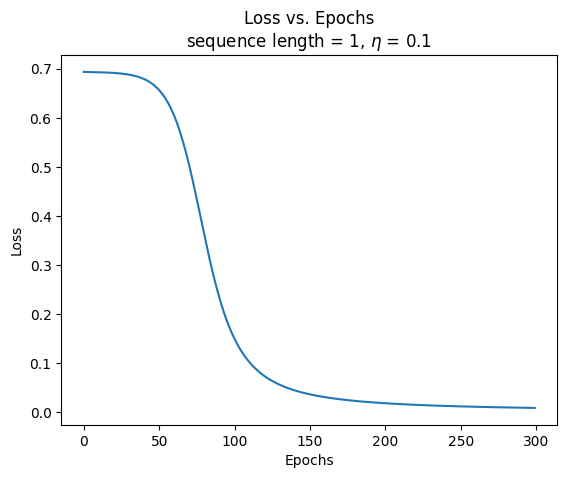

In [12]:
########## YOUR SOLUTION HERE ##########

import itertools

T, D, I, K = 1, 1, 32, 1  # T = sequence length

model = FullyRecurrentNetwork(D, I, K)
eta = 0.1  # learning rate
epochs = 300  # number of updates
losses = []
generator = generate_data(T)

for i in range(epochs):
    x, y = next(itertools.islice(generator, i, None))

    loss = model.forward(x, y)
    model.backward()
    model.update(eta)

    losses.append(loss)


plt.plot(losses)
plt.title('Loss vs. Epochs\n'
          + rf'sequence length = {T}, $\eta$ = {eta}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [13]:
import itertools

def tune_hyperparams(etas, epochs, T, D, I, K):
    fig, axs = plt.subplots(
        len(etas),
        len(epochs),
        figsize=(5 * len(epochs), 3.5 * len(etas))
    )
    fig.set_tight_layout({'h_pad': 2})

    for i, eta in enumerate(etas):
        for j, epoch in enumerate(epochs):
            model = FullyRecurrentNetwork(D, I, K)
            generator = generate_data(T)

            losses = []

            for l in range(epoch):
                x, y = next(itertools.islice(generator, l, None))

                loss = model.forward(x, y)
                model.backward()
                model.update(eta)

                losses.append(np.average(loss))

            axs[i][j].plot(losses)
            axs[i][j].set_title(
                'Loss vs. Epochs\n' +
                rf'T = {T}, $\eta$ = {eta}, epochs = {epoch}',
                y=1.08
            )
            axs[i][j].set_xlabel('Epochs')
            axs[i][j].set_ylabel('Loss')

    plt.show()

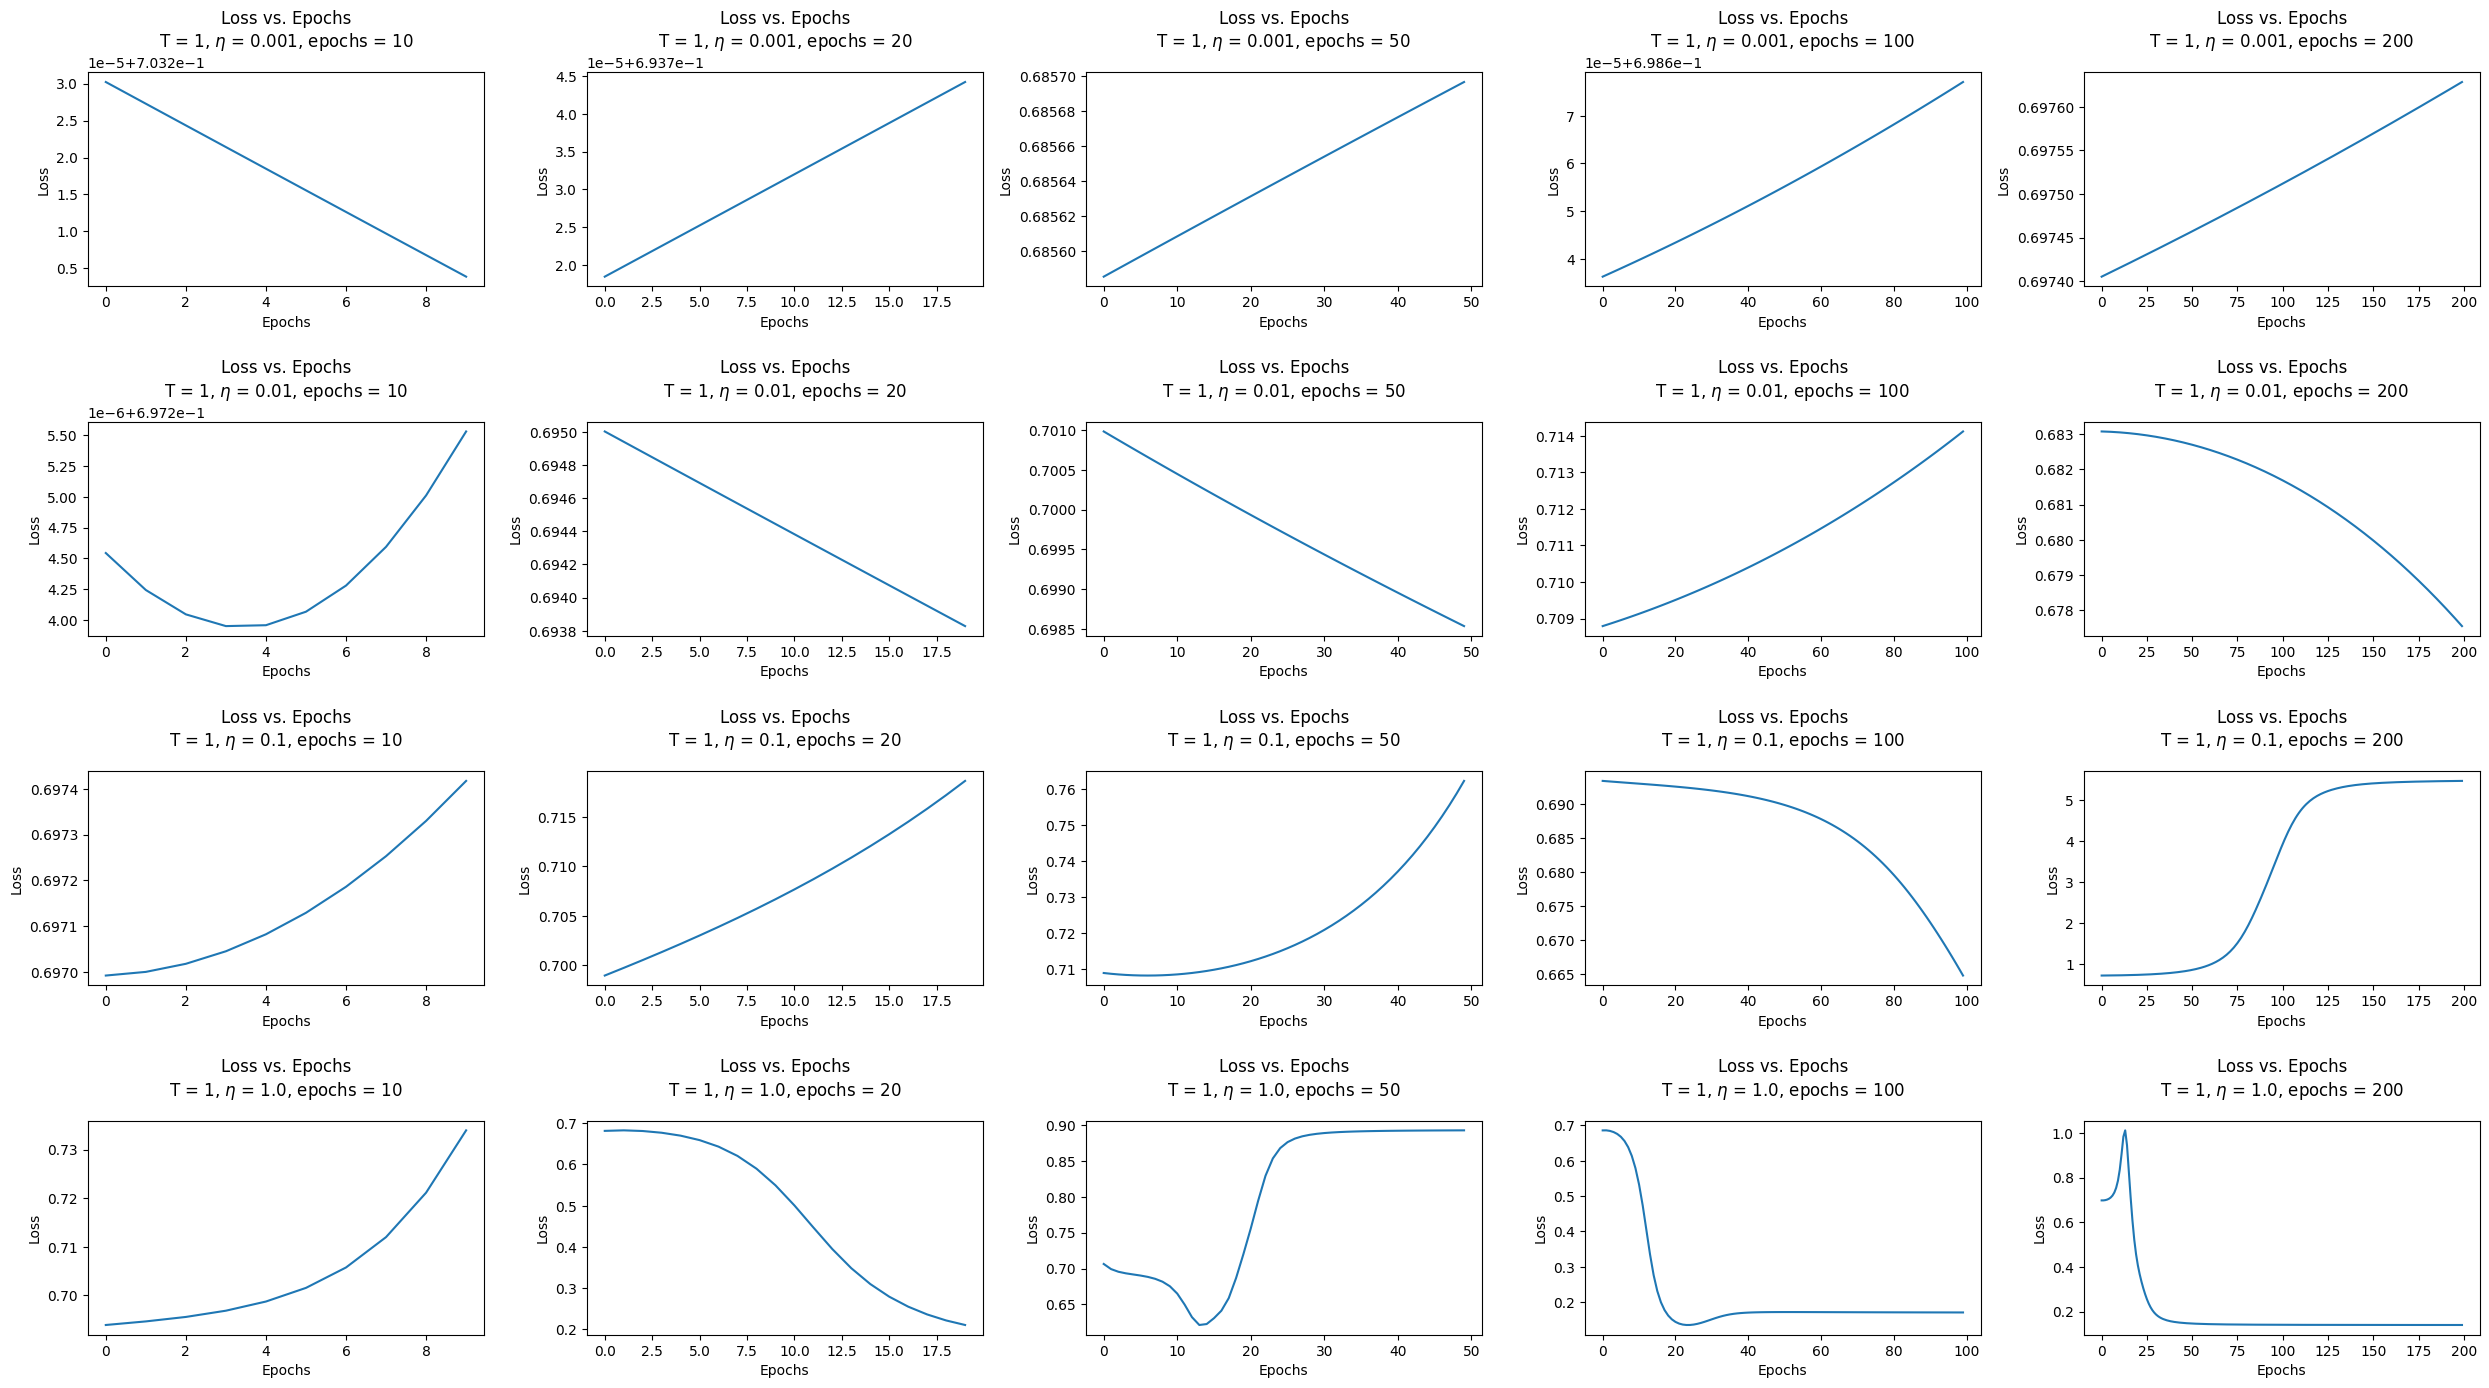

In [14]:
T, D, I, K = 1, 1, 32, 1  # T = sequence length

etas = [0.001, 0.01, 0.1, 1.0]
epochs = [10, 20, 50, 100, 200]

tune_hyperparams(etas, epochs, T, D, I, K)

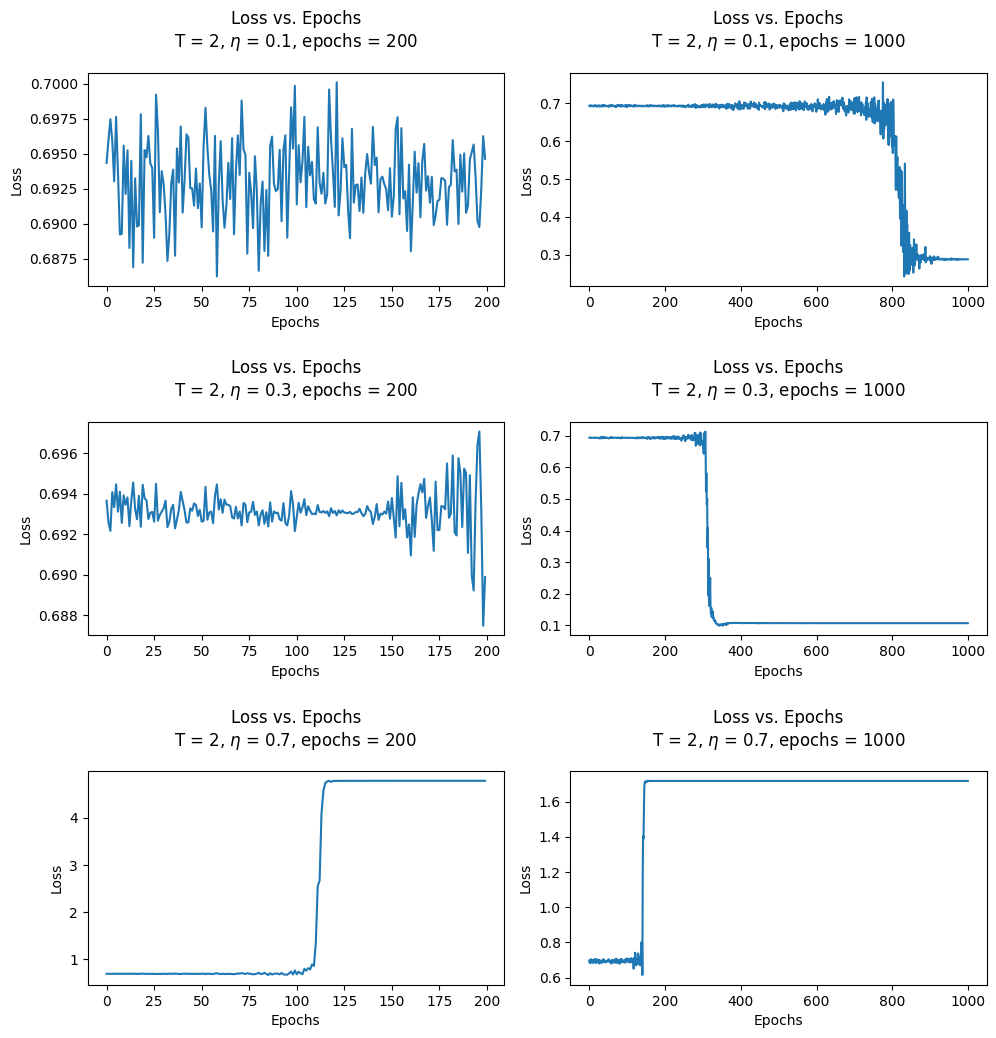

In [15]:
T, D, I, K = 2, 1, 32, 1  # T = sequence length

etas = [0.1, 0.3, 0.7]
epochs = [200, 1000]

tune_hyperparams(etas, epochs, T, D, I, K)

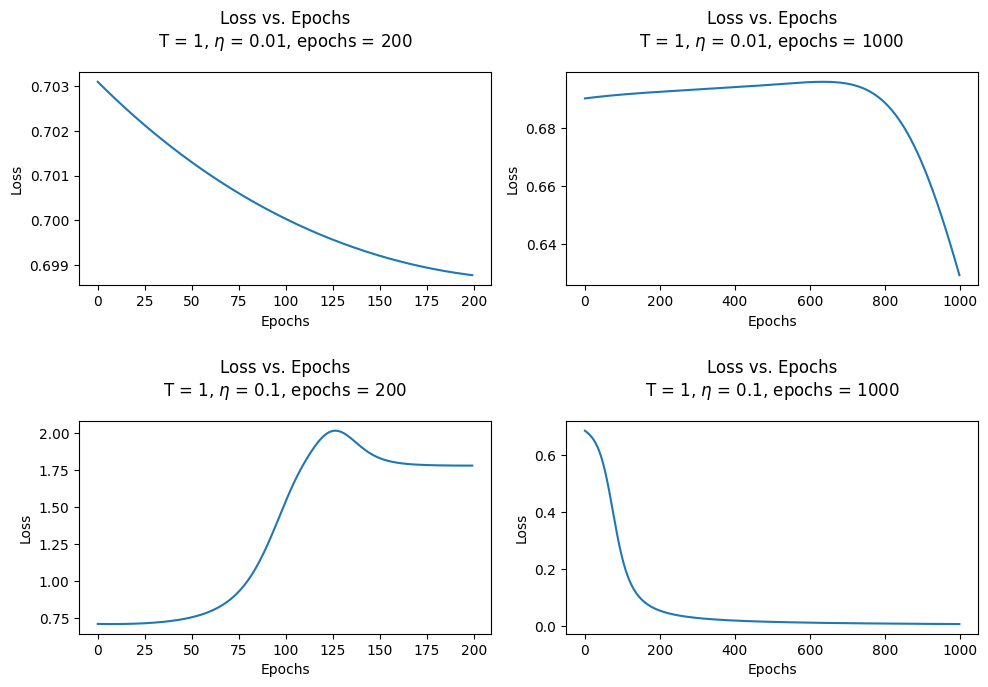

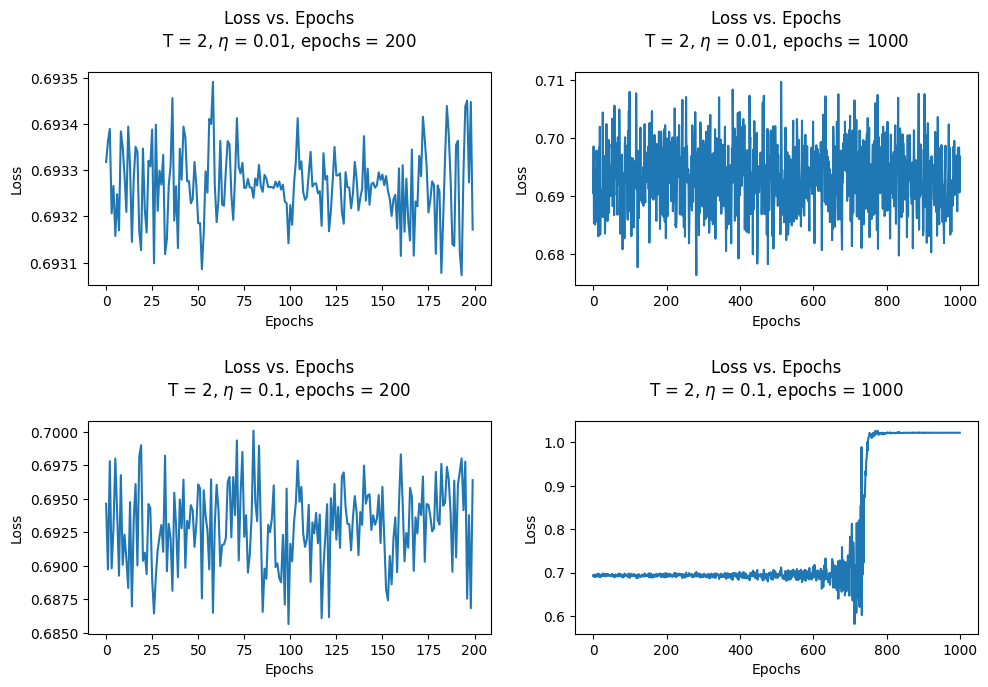

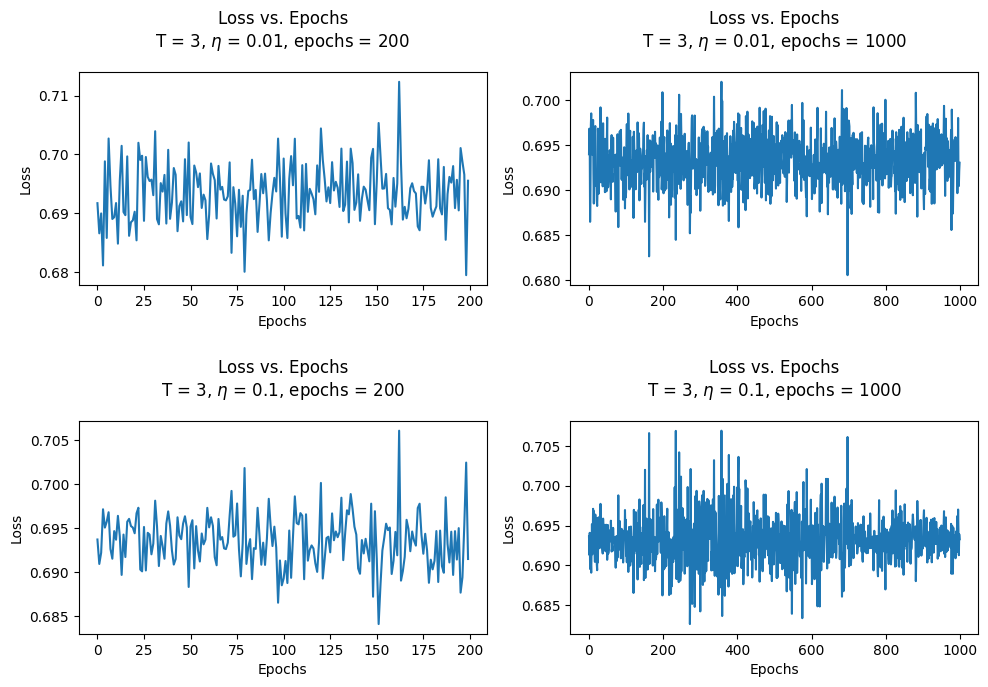

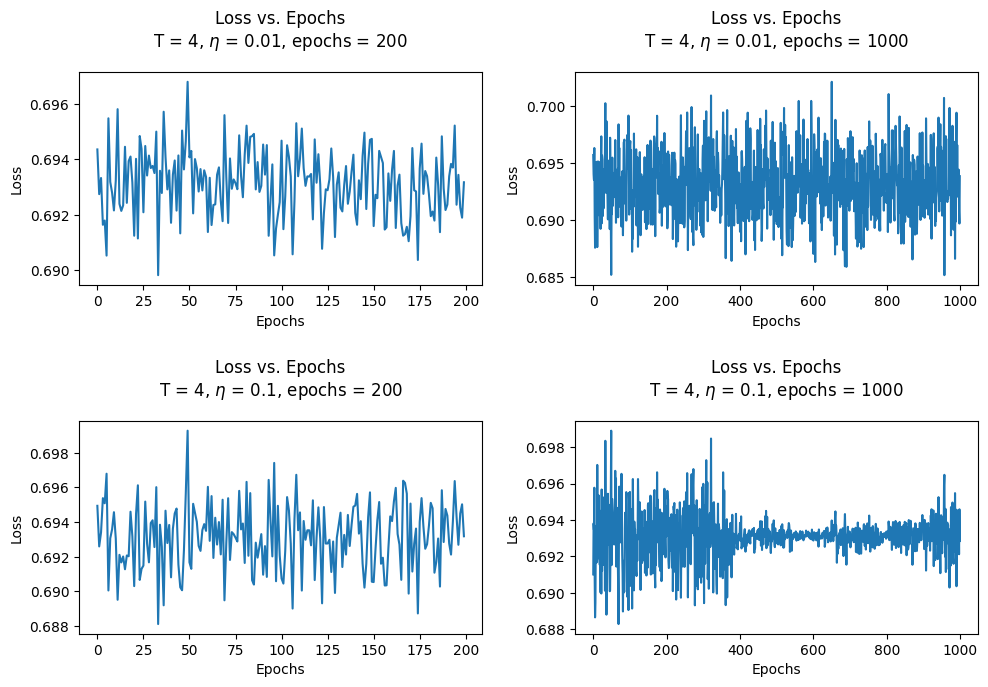

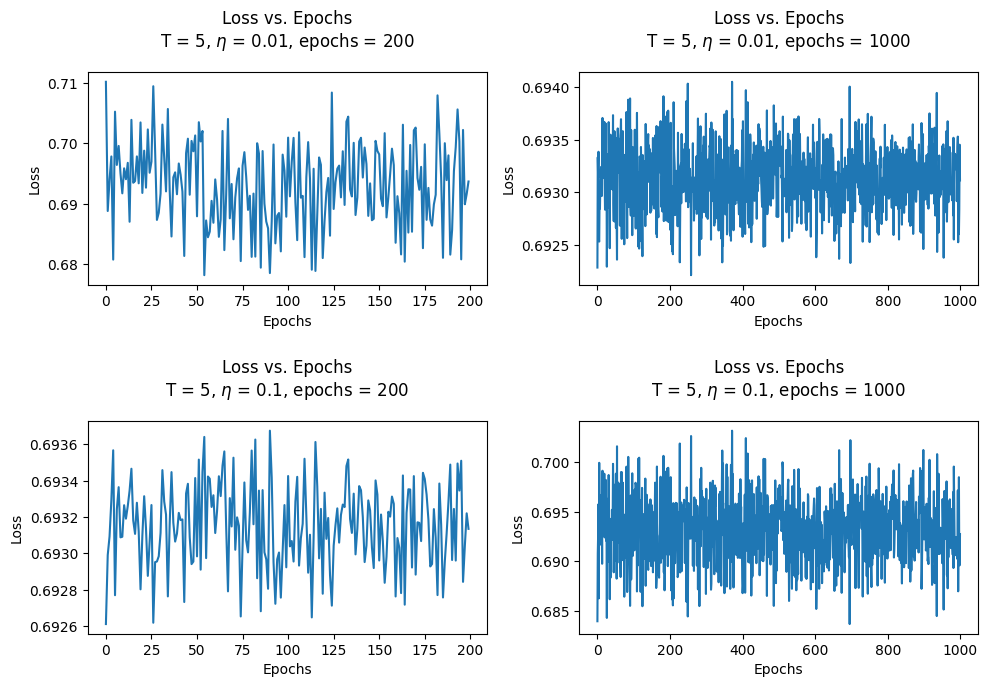

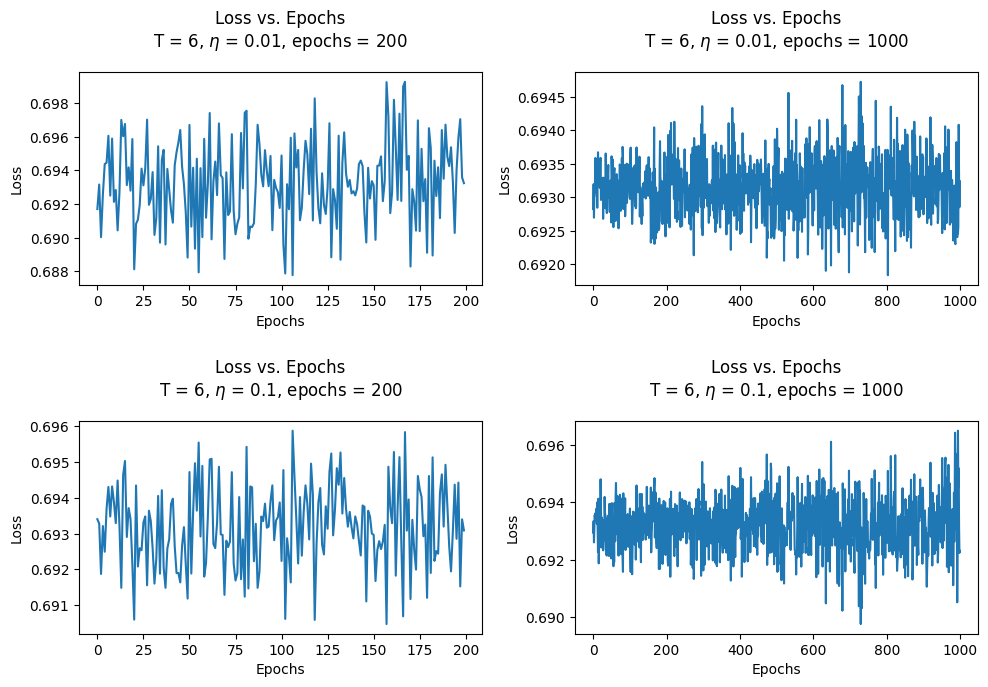

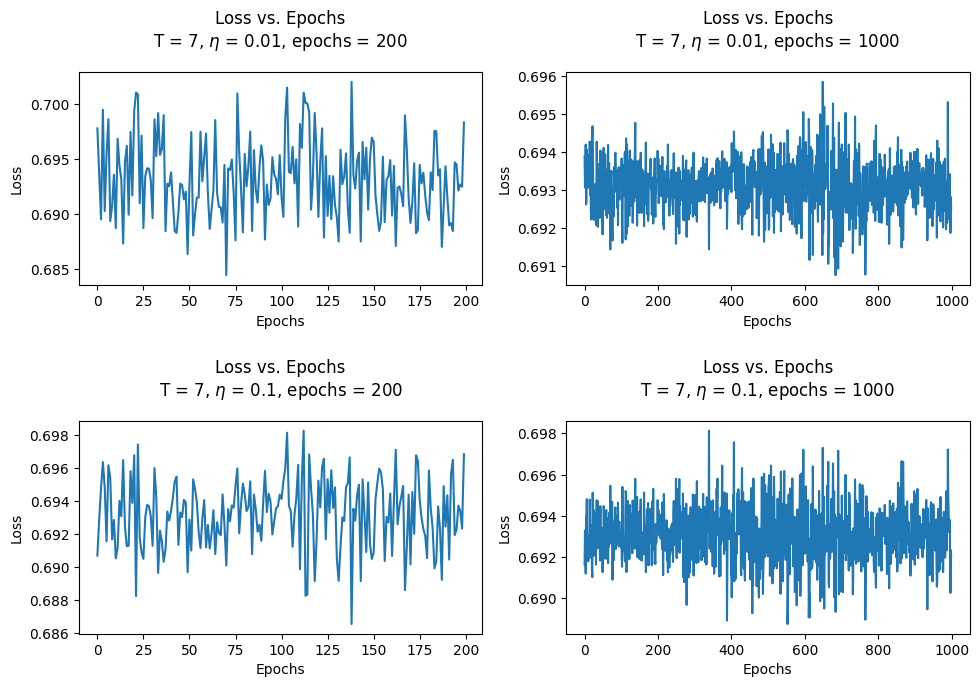

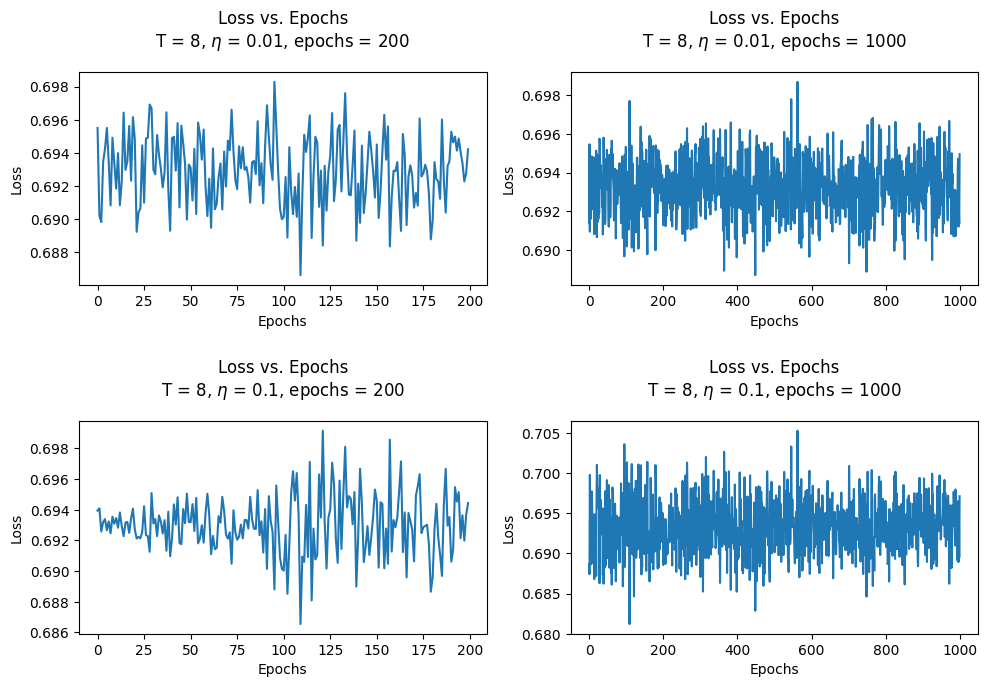

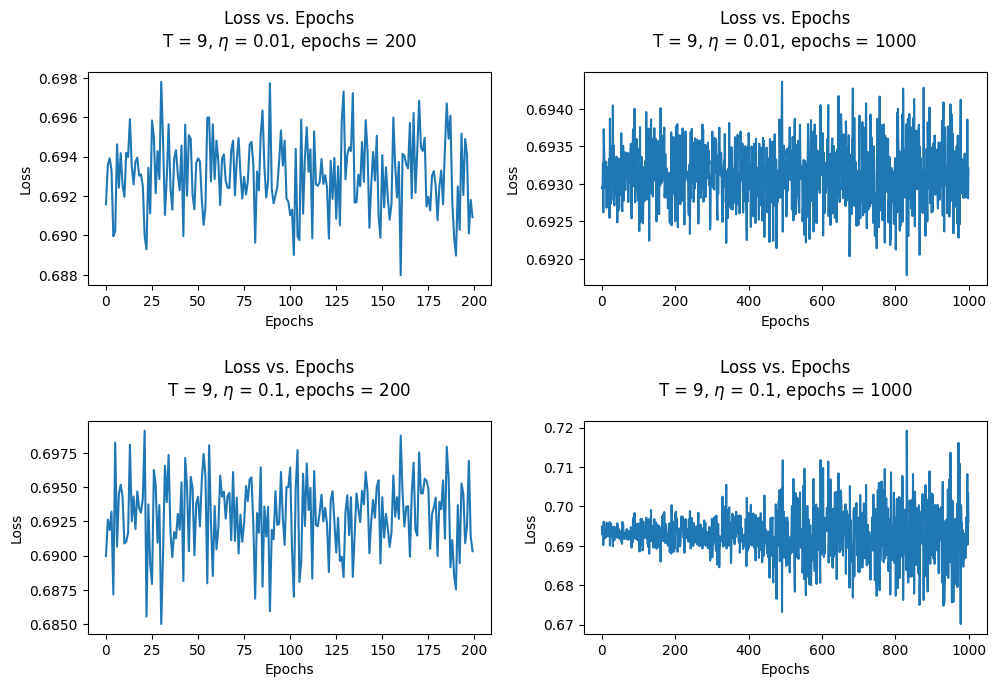

In [16]:
for t in range(1, 10):
    tune_hyperparams([0.01, 0.1], [200, 1000], t, D, I, K)

## Exercise 7: The Vanishing Gradient Problem

Analyze why the network is incapable of learning long-term dependencies. Show that $\|\frac{\partial a(T)}{\partial a(1)}\|_2 \leq \|R\|_2^{T-1}$ , where $\|\cdot\|_2$ is the spectral norm, and discuss how that affects the propagation of error signals through the time dimension of the network.

*Hint: Use the fact that the spectral norm is submultiplicative for square matrices, i.e. $\|AB\|_2 \leq \|A\|_2\|B\|_2$ if $A$ and $B$ are both square.*

########## YOUR SOLUTION HERE ##########

$$
\begin{aligned}
\Big\|\frac{\partial \mathbf{a}(T)}{\partial \mathbf{a}(1)}\Big\|_2
    &\leq \|\mathbf{R}\|_2^{T-1} \\
\Big\|
    \frac{\partial \mathbf{a}(T)}{\partial \mathbf{a}(T - 1)}
    \frac{\partial \mathbf{a}(T - 1)}{\partial \mathbf{a}(T - 2)}
    \dots
    \frac{\partial \mathbf{a}(2)}{\partial \mathbf{a}(1)}
\Big\|_2
    &\leq \|\mathbf{R}\|_2^{T-1} \\
\end{aligned}
$$

We can rewrite $\frac{\partial \mathbf{a}(T)}{\partial \mathbf{a}(T - 1)}$:

$$
\frac{\partial \mathbf{a}(T)}{\partial \mathbf{a}(T - 1)}
= \frac{\partial f(\mathbf{s}(T))}{\partial \mathbf{a}(T-1)}
= \frac{\partial}{\partial \mathbf{a}(1)}
    f(\mathbf{Wx}(T) + \mathbf{Ra}(T-1)) = \\
= \mathbf{R} f'(\mathbf{Wx}(T) + \mathbf{Ra}(T-1))
$$

Therefore, we can write $\|\frac{\partial \mathbf{a}(T)}{\partial \mathbf{a}(1)}\|_2$ as a product:

$$
\begin{aligned}
\Big\|
    \frac{\partial \mathbf{a}(T)}{\partial \mathbf{a}(T - 1)}
    \frac{\partial \mathbf{a}(T - 1)}{\partial \mathbf{a}(T - 2)}
    \dots
    \frac{\partial \mathbf{a}(2)}{\partial \mathbf{a}(1)}
\Big\|_2
    &\leq \|R\|_2^{T-1} \\
\Big\|
    \mathbf{R}^{T-1} \prod_{t=2}^T f'(\mathbf{Wx}(t) + \mathbf{Ra}(t-1))
\Big\|_2
    &\leq \|R\|_2^{T-1} \\
\end{aligned}
$$

Apply the hint:

$$
\begin{aligned}
\Big\|
    \mathbf{R}^{T-1} \prod_{t=2}^T f'(\mathbf{Wx}(t) + \mathbf{Ra}(t-1))
    \Big\|_2
&\leq \|R\|_2^{T-1} \\
\| \mathbf{R}^{T-1}\|_2 \cdot
    \Big\| \prod_{t=2}^T f'(\mathbf{Wx}(t) + \mathbf{Ra}(t-1)) \Big\|_2
&\leq \|R\|_2^{T-1} \\
\| \mathbf{R}\|^{T-1}_2 \cdot
    \prod_{t=2}^T \Big\|
        f'(\mathbf{Wx}(t) + \mathbf{Ra}(t-1))
    \Big\|_2
&\leq \|R\|_2^{T-1} \\
\end{aligned}
$$

Left term equals the right hand side, therefore, for inequality to hold the right term must be $\leq 1$.

$$
f(s) = \tanh(s) \Rightarrow f'(s) = 1 - \tanh^2(s) \Rightarrow f'(s) \in (0, 1]
$$